In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
from scipy import interpolate
import os
import matplotlib.pyplot as plt
%matplotlib notebook

In [5]:
plt.close('all')

# 1. Read data
#csvfile = os.path.join(os.getcwd(), 'data', 'ecg_ppg_motion.csv')
#csvfile = os.path.join(os.getcwd(), 'data', 'ecg_ppg_clean.csv')
data = pd.read_csv("ecg_ppg_clean.csv")
data.tail() #nan given to ppg due to different sampling rate


,timestamps_ecg,ecg,timestamps_ppg_1_green,ppg_1_green,timestamps_ppg_1_red,ppg_1_red,timestamps_ppg_1_ir,ppg_1_ir,timestamps_ppg_2_green,ppg_2_green,timestamps_ppg_2_red,ppg_2_red,timestamps_ppg_2_ir,ppg_2_ir
15696,1949578.0,-795.746835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15697,1949656.0,-713.493671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15698,1949734.0,-620.556962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15699,1949812.0,-590.886076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15700,1949890.0,-599.392405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# 2. Pre-clean data and convert to numpy

#data = pd.read_csv(csvfile).dropna() #read file and remove all nans
def get_channel(ch1, ch2): #time and amplitde channels
    time = data[ch1].dropna().to_numpy(dtype = 'float')
    amplitude = data[ch2].dropna().to_numpy(dtype = 'float')
    return time, amplitude
    
ecg_time, ecg = get_channel('timestamps_ecg', 'ecg') #names in df
ppg_time, ppg = get_channel('timestamps_ppg_1_ir', 'ppg_1_ir') #one ppg as an example 
    


<IPython.core.display.Javascript object>


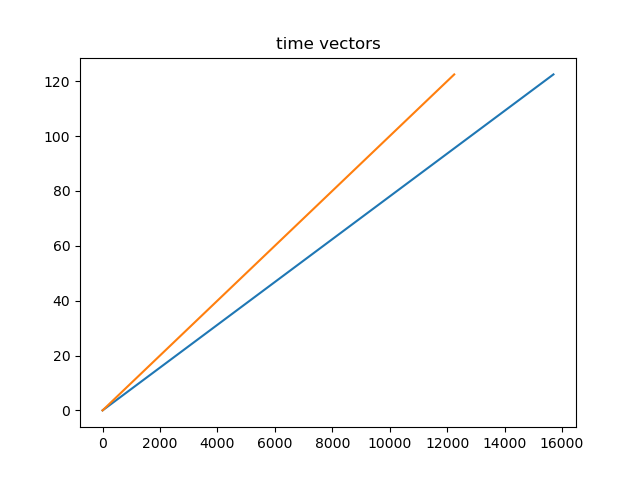

<IPython.core.display.Javascript object>


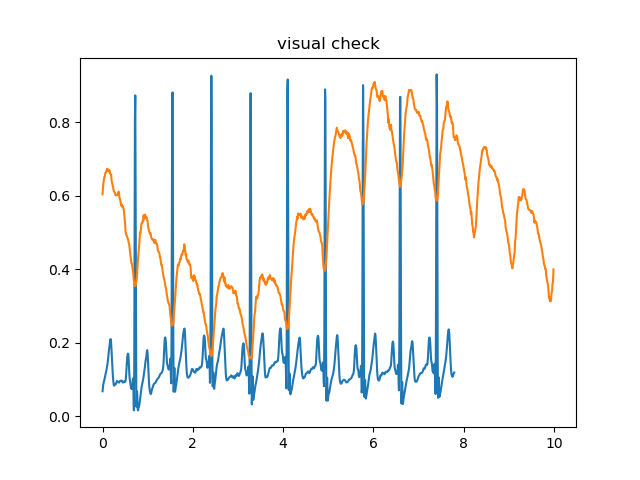

ecg dt = 128.2051282051282
ppg dt = 100.0


In [7]:
#3. Plot data for visual inspection
def normalize(arr):
    arr = arr - np.min(arr)
    arr = arr / np.max(arr)
    return arr

ecg = normalize(ecg)

ppg = ppg*-1 #reflection mode ppg need a flip
ppg = normalize(ppg)

ecg_time = (ecg_time - ecg_time[0])/10000 #[s]
ppg_time = (ppg_time - ppg_time[0])/10000

plt.figure()
plt.plot(ecg_time)
plt.plot(ppg_time)
plt.title('time vectors')

plt.figure()
plt.plot(ecg_time[:1000], ecg[:1000])
plt.plot(ppg_time[:1000], ppg[:1000])
plt.title('visual check')

print('ecg dt = ' + str(1/np.mean(np.diff(ecg_time)))) #average fs
print('ppg dt = ' + str(1/np.mean(np.diff(ppg_time)))) #average fs



<IPython.core.display.Javascript object>


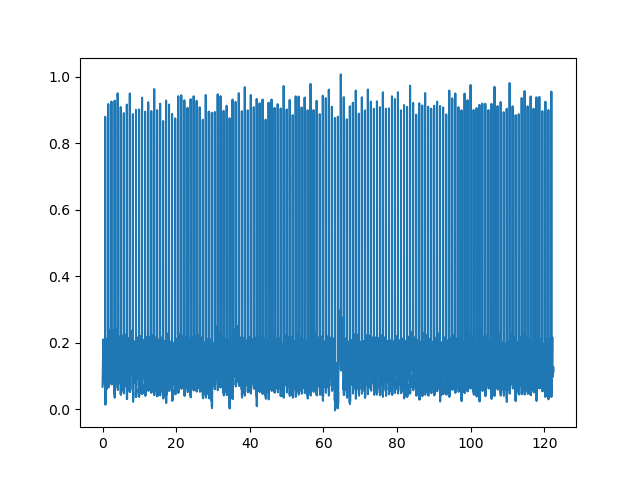

<IPython.core.display.Javascript object>


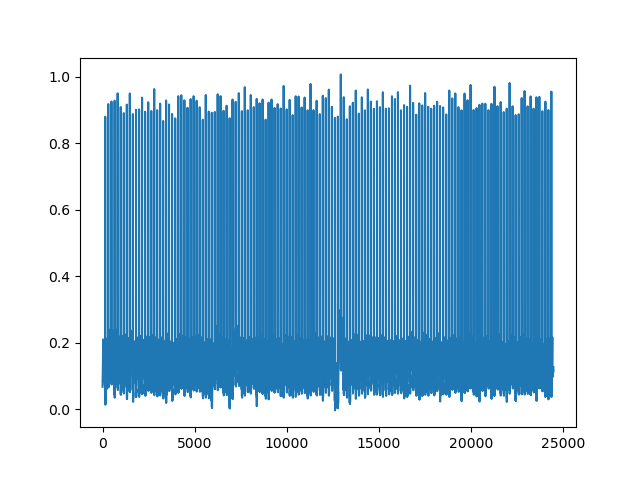

24491
24491


In [12]:
#4. Resampling
def spliner(ind_orig, val_orig, new_ind):
    spline_fn = interpolate.interp1d(ind_orig, val_orig, kind='cubic')
    return spline_fn(new_ind)  

fs_new = 200
dt = 1/fs_new
T = min(ecg_time[-1], ppg_time[-1])
n = fs_new*T
time_new = np.arange(n+1)*dt #approximate of given timestamps

resampled_ecg = spliner(ecg_time, ecg, time_new)
resampled_ppg = spliner(ppg_time, ppg, time_new)

plt.figure()
plt.plot(ecg_time, ecg)
plt.plot(time_new, resampled_ecg)

# plt.figure()
# plt.plot(ppg_time, ppg)
# plt.plot(time_new, resampled_ppg)

plt.figure()
plt.plot(resampled_ppg)
plt.plot(resampled_ecg)

print(len(resampled_ecg))
print(len(resampled_ppg))

<IPython.core.display.Javascript object>


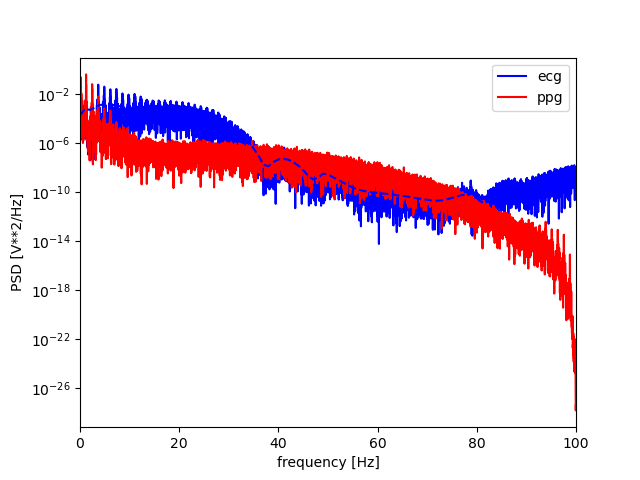

(0.0, 100.0)

In [9]:
#3. check spectral components
f_ecg, Pxx_ecg = signal.welch(resampled_ecg, fs_new, nperseg=200*120)
f_ppg, Pxx_ppg = signal.welch(resampled_ppg, fs_new, nperseg=200*120)
f_ecg_short, Pxx_ecg_short = signal.welch(resampled_ecg, fs_new, nperseg=200)

plt.figure()
plt.semilogy(f_ecg, Pxx_ecg, 'b')
plt.semilogy(f_ppg, Pxx_ppg, 'r')
plt.semilogy(f_ecg_short, Pxx_ecg_short, '--b')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend(['ecg', 'ppg'])
plt.xlim([0,100])

<IPython.core.display.Javascript object>


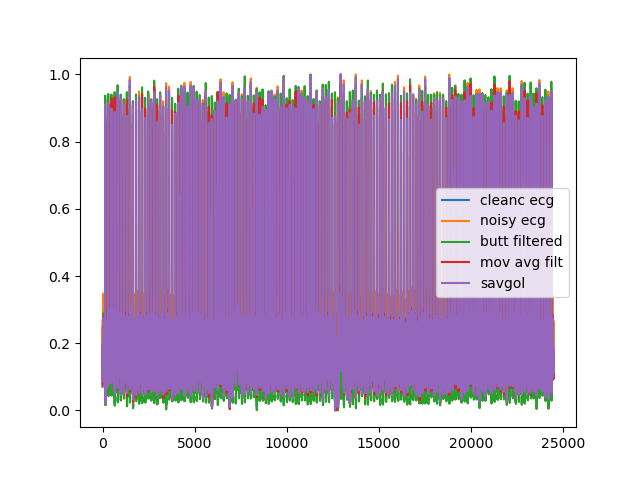

In [10]:
#4. Filter the signals
def bpf(arr, fs, lf=0.5, hf=50, order=2):    
    wbut = [2*lf/fs, 2*hf/fs] 
    bbut, abut = signal.butter(order, wbut, btype = 'bandpass')       
    return signal.filtfilt(bbut, abut, arr)   

resampled_ecg_noisy = resampled_ecg + np.random.randn(len(resampled_ecg))*0.005
resampled_ecg_noisy = resampled_ecg + np.sin(2*np.pi*60*np.arange(len(resampled_ecg))/200)*0.1

ecg_butt_filt = bpf(resampled_ecg_noisy, hf=25, fs = 200)

ecg_movavg_lp = np.convolve(np.ones(5), resampled_ecg_noisy, 'same') / 5
#ecg_movavg_hp = ecg - ecg_movavg_lp #this is high-pass

ecg_savgol = signal.savgol_filter(resampled_ecg_noisy, 5,2,deriv=0)


plt.figure()
plt.plot(normalize(resampled_ecg), label = 'cleanc ecg')
plt.plot(normalize(resampled_ecg_noisy), label = 'noisy ecg')
plt.plot(normalize(ecg_butt_filt), label = 'butt filtered')

plt.plot(normalize(ecg_movavg_lp), label = 'mov avg filt')
plt.plot(normalize(ecg_savgol), label = 'savgol')
plt.legend()

